# Optimize the design of the transmon pocket

To keep the structure roughly the same, we change the width of the metal pad in the transmon pocket. Intuitively, the wider the transmon pocket, the larger the capacitance would be. To increase the qubit frequency, we need to increase the capacitance.

## Steps
1. Construct the function that takes in padwidth and return a capacitance between ground and the metal pad
2. Function that takes in frequency and spit out desired capacitance
3. Optimize and find the desired design

In [82]:

import astropy.units as u
import astropy.constants as c
import numpy as np
import matplotlib.pyplot as plt

from scipy import optimize

%matplotlib inline

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
#This imports the necessary path to draw the single pad transmon design. 
import sys
sys.path.append('Customized_Components')
from single_pad_transmon_pocket import TransmonPocket_Single

import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [4]:
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings

In [5]:
design = designs.DesignPlanar()
gui = MetalGUI(design)

### Construct a single transmon pad to test the code

In [26]:
design.overwrite_enabled = True #This makes it possible to edit the designs later on. 

design.delete_all_components()

options = dict(pad_width = '200um',
pocket_width = '300um',
pad_pocket_distance_top = '60um',
pos_x = '0',
pad_height = '200um',
pos_y = '0',
connection_pads = dict(
    a = dict(loc_W  = 1, 
             loc_H =  1, 
             pad_gap = '10um',
             pad_height = '20um',
             pad_width = '100um',
             pad_cpw_extent =  '10um',
             pocket_rise = '0um',
             cpw_extend = '5um')))

q1 = TransmonPocket_Single(design,'Q1',options = options)

gui.rebuild()
gui.zoom_on_components(['Q1'])

In [27]:
from qiskit_metal.analyses.quantization import LOManalysis
c1 = LOManalysis(design, "q3d")

In [28]:
c1.sim.setup.min_passes  = 1
c1.sim.setup.max_passes = 5
print(c1.sim.setup)

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'freq_ghz': 5.0, 'save_fields': False, 'enabled': True, 'max_passes': 5, 'min_passes': 1, 'min_converged_passes': 2, 'percent_error': 0.5, 'percent_refinement': 30, 'auto_increase_solution_order': True, 'solution_order': 'High', 'solver_type': 'Iterative'}


In [29]:
c1.sim.run(components=['Q1'], open_terminations=[('Q1', 'a')])#, ('Q1', 'bus1'), ('Q1', 'bus2')])
c1.sim.capacitance_matrix 

c1.sim._get_results_from_renderer()
c_mat = c1.sim.capacitance_matrix

INFO 09:56PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 09:56PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:56PM [analyze]: Analyzing setup Setup
INFO 09:56PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp1tpi2jws.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:56PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp_9ly42no.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:56PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpqgdvg66z.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 09:56PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpwvply9hr.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

In [30]:
c_mat

,a_connector_pad_Q1,ground_main_plane,pad_top_Q1
a_connector_pad_Q1,23.63791,-13.83121,-9.42478
ground_main_plane,-13.83121,122.84866,-67.19156
pad_top_Q1,-9.42478,-67.19156,80.04586


In [24]:
C = c_mat['ground_main_plane']['a_connector_pad_Q1']

In [25]:
C

-11.46906

### Sainity check the general trend of capacitance

This ensures that capacitance of the top pad to ground is a roughly linear funciton. 

In [99]:
def find_Cap(width):
    if type(width)=='astropy.units.quantity.Quantity':
        width = width.to(u.um)
    else:
        width = width[0]*u.um
    design.delete_all_components()

    options = dict(pad_width = '{}um'.format(width.value),
    pocket_width = '300um',
    pad_pocket_distance_top = '60um',
    pos_x = '0',
    pad_height = '200um',
    pos_y = '0',
    connection_pads = dict(
        a = dict(loc_W  = 1, 
                loc_H =  1, 
                pad_gap = '10um',
                pad_height = '20um',
                pad_width = '100um',
                pad_cpw_extent =  '10um',
                pocket_rise = '0um',
                cpw_extend = '5um')))

    q1 = TransmonPocket_Single(design,'Q1',options = options)

    gui.rebuild()
    gui.zoom_on_components(['Q1'])
    
    
    c1 = LOManalysis(design, "q3d")
    c1.sim.setup.min_passes  = 10
    c1.sim.setup.max_passes = 20
    
    c1.sim.run(components=['Q1'], open_terminations=[('Q1', 'a')])#, ('Q1', 'bus1'), ('Q1', 'bus2')])
    c1.sim.capacitance_matrix 

    c1.sim._get_results_from_renderer()
    c_mat = c1.sim.capacitance_matrix
    
    print(c_mat)
    
    return(c_mat['ground_main_plane']['pad_top_Q1'])
    

In [77]:
widths = np.linspace(70*u.um, 250*u.um, 20)
result = []
for i, width in enumerate(widths):
    result += [find_Cap(width)]


INFO 01:59PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 01:59PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:59PM [analyze]: Analyzing setup Setup
INFO 01:59PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpx1xp6jq1.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:59PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp1uiz93rj.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:59PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmptp2febwu.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 01:59PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp1mv1vlcl.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            30.26596          -21.21163    -8.35404
ground_main_plane            -21.21163           97.30975   -33.92085
pad_top_Q1                    -8.35404          -33.92085    44.19702


INFO 01:59PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 01:59PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:59PM [analyze]: Analyzing setup Setup
INFO 02:00PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpbcetvp2n.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:00PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpgzkr2cyh.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:00PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmplq1inplx.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:00PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpg9x1rilh.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            30.09026          -20.53847    -8.88490
ground_main_plane            -20.53847           99.01598   -36.38364
pad_top_Q1                    -8.88490          -36.38364    47.32006


INFO 02:00PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:00PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:00PM [analyze]: Analyzing setup Setup
INFO 02:01PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpgqpv0pwy.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:01PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp6yf5lbc1.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:01PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpsqybgbx7.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:01PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpv0myjgmu.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            29.81910          -19.85024    -9.33330
ground_main_plane            -19.85024          100.66956   -38.82068
pad_top_Q1                    -9.33330          -38.82068    50.33375


INFO 02:01PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:01PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:01PM [analyze]: Analyzing setup Setup
INFO 02:02PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpe56_dmav.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:02PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp9xi6o8hn.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:02PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmptdbcay5r.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:02PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmprgknyyj2.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            29.49889          -19.20974    -9.68308
ground_main_plane            -19.20974          102.38955   -41.27234
pad_top_Q1                    -9.68308          -41.27234    53.26091


INFO 02:02PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:02PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:02PM [analyze]: Analyzing setup Setup
INFO 02:03PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpj4ry2bpx.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:03PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpuvr0gz5t.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:03PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp23cbce2d.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:03PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpw4eaoz27.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            29.11661          -18.60605    -9.93134
ground_main_plane            -18.60605          104.13233   -43.71274
pad_top_Q1                    -9.93134          -43.71274    56.07388


INFO 02:03PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:03PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:03PM [analyze]: Analyzing setup Setup
INFO 02:04PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp14fxdd3h.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:04PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpf_zipf_d.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:04PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp9ih71gqw.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:04PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpb89eksja.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            28.71203          -18.05708   -10.10065
ground_main_plane            -18.05708          105.95839   -46.18039
pad_top_Q1                   -10.10065          -46.18039    58.83294


INFO 02:04PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:04PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:04PM [analyze]: Analyzing setup Setup
INFO 02:05PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp5s_t3a77.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:05PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp8hs5kfs9.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:05PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpwbc84pyq.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:05PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmplkfo7p8g.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            28.26491          -17.54962   -10.18306
ground_main_plane            -17.54962          107.86543   -48.68717
pad_top_Q1                   -10.18306          -48.68717    61.54274


INFO 02:05PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:05PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:05PM [analyze]: Analyzing setup Setup
INFO 02:05PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp2ahmxh8x.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:05PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpa2_4h7cb.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:05PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpolox4qwy.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:05PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpcy1qfr8l.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            27.82629          -17.07684   -10.23855
ground_main_plane            -17.07684          109.89433   -51.28050
pad_top_Q1                   -10.23855          -51.28050    64.30975


INFO 02:05PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:05PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:05PM [analyze]: Analyzing setup Setup
INFO 02:06PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpy3k7j3mk.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:06PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp4qnb0kes.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:06PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpb4tct8c5.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:06PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp3800ft4q.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            27.36013          -16.61089   -10.25765
ground_main_plane            -16.61089          111.87734   -53.82635
pad_top_Q1                   -10.25765          -53.82635    66.99299


INFO 02:06PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:06PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:06PM [analyze]: Analyzing setup Setup
INFO 02:07PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpvliwmadp.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:07PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpz90bo7h4.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:07PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpq9c12c6u.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:07PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp7bfc62o1.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            26.90387          -16.17442   -10.25632
ground_main_plane            -16.17442          113.87726   -56.35466
pad_top_Q1                   -10.25632          -56.35466    69.63416


INFO 02:07PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:07PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:07PM [analyze]: Analyzing setup Setup
INFO 02:08PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmppxlqi30e.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:08PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpcffkh3f7.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:08PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpo_b14lg7.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:08PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpwg62mlm4.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            26.43749          -15.74861   -10.23358
ground_main_plane            -15.74861          115.93383   -58.91432
pad_top_Q1                   -10.23358          -58.91432    72.28196


INFO 02:08PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:08PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:08PM [analyze]: Analyzing setup Setup
INFO 02:08PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp3c1w6zu7.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:08PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpvwj614oh.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:08PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp7tqc0d3y.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:08PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpstyljxit.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            25.98714          -15.37258   -10.21630
ground_main_plane            -15.37258          118.04815   -61.62797
pad_top_Q1                   -10.21630          -61.62797    75.09963


INFO 02:08PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:08PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:08PM [analyze]: Analyzing setup Setup
INFO 02:09PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp0bsj_41r.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:09PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp6l81w4yq.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:09PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpd95ylc75.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:09PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpa8g_jas1.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            25.52791          -14.94938   -10.15585
ground_main_plane            -14.94938          120.41731   -64.38414
pad_top_Q1                   -10.15585          -64.38414    77.89168


INFO 02:09PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:09PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:09PM [analyze]: Analyzing setup Setup
INFO 02:10PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpoo2x5lc7.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:10PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmphau0fs7p.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:10PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp_k49oigr.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:10PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpuignrw9r.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            25.02558          -14.56231   -10.09689
ground_main_plane            -14.56231          122.58085   -67.13772
pad_top_Q1                   -10.09689          -67.13772    80.70662


INFO 02:10PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:10PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:10PM [analyze]: Analyzing setup Setup
INFO 02:10PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp9ne3cx7e.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:10PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp2_4zr0pa.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:10PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp2wkpctva.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:10PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp372xs2ik.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            24.57473          -14.19563   -10.02734
ground_main_plane            -14.19563          125.02545   -70.03737
pad_top_Q1                   -10.02734          -70.03737    83.64223


INFO 02:10PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:10PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:10PM [analyze]: Analyzing setup Setup
INFO 02:11PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp023gi0zb.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:11PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp3ifz8chp.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:11PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp6pln5bmq.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:11PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpepk52dng.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            24.09602          -13.82281    -9.93468
ground_main_plane            -13.82281          127.56663   -73.03417
pad_top_Q1                    -9.93468          -73.03417    86.64837


INFO 02:11PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:11PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:11PM [analyze]: Analyzing setup Setup
INFO 02:12PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpkegh0s9a.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:12PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpklan6_7v.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:12PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpgw3jib5j.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:12PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpcdhwspvk.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            23.62924          -13.46463    -9.83873
ground_main_plane            -13.46463          130.32838   -76.25466
pad_top_Q1                    -9.83873          -76.25466    89.87286


INFO 02:12PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:12PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:12PM [analyze]: Analyzing setup Setup
INFO 02:12PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpust63bgh.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:12PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp8hvfry98.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:12PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpjdqct16y.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:12PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp0omd25w3.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            23.17236          -13.11427    -9.74361
ground_main_plane            -13.11427          133.25422   -79.60302
pad_top_Q1                    -9.74361          -79.60302    93.21392


INFO 02:12PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:12PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:12PM [analyze]: Analyzing setup Setup
INFO 02:13PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpnx74wdny.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:13PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmphqza63oi.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:13PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpqn0isftm.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:13PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpmgl7k_ar.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.69599          -12.76343    -9.62852
ground_main_plane            -12.76343          136.51229   -83.28620
pad_top_Q1                    -9.62852          -83.28620    96.86954


INFO 02:13PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:13PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:13PM [analyze]: Analyzing setup Setup
INFO 02:14PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmph2x97cfh.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:14PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp48l0cd7v.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:14PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp8sfwp8zm.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:14PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp9urm9_ta.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.24106          -12.42921    -9.51669
ground_main_plane            -12.42921          140.04010   -87.22105
pad_top_Q1                    -9.51669          -87.22105   100.77634


The plot below shows that when we increase the distance to the two sides of the metal pads to the pocket edge, the capacitance decreases. In this simulation, we change the distance by changing the size of the metal pad in the pocket

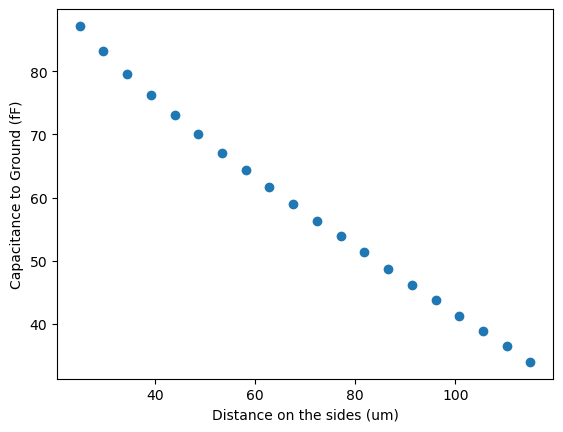

In [78]:
plt.scatter((300*u.um-widths)/2, -np.array(result))
plt.xlabel('Distance on the sides (um)')
plt.ylabel('Capacitance to Ground (fF)')
plt.show()

In [79]:
def find_Cap(height):
    height = height.to(u.um)
    design.delete_all_components()

    options = dict(pad_width = '250um',
    pocket_width = '300um',
    pad_pocket_distance_top = '60um',
    pos_x = '0',
    pad_height = '{}um'.format(height.value),
    pos_y = '0',
    connection_pads = dict(
        a = dict(loc_W  = 1, 
                loc_H =  1, 
                pad_gap = '10um',
                pad_height = '20um',
                pad_width = '100um',
                pad_cpw_extent =  '10um',
                pocket_rise = '0um',
                cpw_extend = '5um')))

    q1 = TransmonPocket_Single(design,'Q1',options = options)

    gui.rebuild()
    gui.zoom_on_components(['Q1'])
    
    
    c1 = LOManalysis(design, "q3d")
    c1.sim.setup.min_passes  = 10
    c1.sim.setup.max_passes = 20
    
    c1.sim.run(components=['Q1'], open_terminations=[('Q1', 'a')])#, ('Q1', 'bus1'), ('Q1', 'bus2')])
    c1.sim.capacitance_matrix 

    c1.sim._get_results_from_renderer()
    c_mat = c1.sim.capacitance_matrix
    
    print(c_mat)
    
    return(c_mat)

In [80]:
heights = np.linspace(70*u.um, 240*u.um, 15)
result_height = []
for height in heights:
    result_height += [find_Cap(height)]

INFO 02:32PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:32PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:32PM [analyze]: Analyzing setup Setup
INFO 02:33PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpr4xf0o9o.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:33PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpjhaosnha.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:33PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpsqfo8fot.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:33PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp0b58ld2n.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.26665          -12.97580    -8.92333
ground_main_plane            -12.97580          101.08246   -49.22123
pad_top_Q1                    -8.92333          -49.22123    60.10188


INFO 02:33PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:33PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:33PM [analyze]: Analyzing setup Setup
INFO 02:33PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp7xxfyodj.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:33PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpwvk5jvo4.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:33PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpqpvybrf2.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:33PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpny96yjzo.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.27758          -12.86882    -9.05461
ground_main_plane            -12.86882          105.18504   -53.27981
pad_top_Q1                    -9.05461          -53.27981    64.51843


INFO 02:33PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:33PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:33PM [analyze]: Analyzing setup Setup
INFO 02:34PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpd8h6759j.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:34PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpfy88cmei.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:34PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp65q_n35z.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:34PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpb2i75dti.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.26995          -12.78617    -9.14509
ground_main_plane            -12.78617          109.11838   -57.14556
pad_top_Q1                    -9.14509          -57.14556    68.68404


INFO 02:34PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:34PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:34PM [analyze]: Analyzing setup Setup
INFO 02:35PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpifk3vnea.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:35PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpue2j7mir.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:35PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpunaoabiq.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:35PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpsc80tgfq.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.27284          -12.75975    -9.22896
ground_main_plane            -12.75975          112.81989   -60.83502
pad_top_Q1                    -9.22896          -60.83502    72.68869


INFO 02:35PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:35PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:35PM [analyze]: Analyzing setup Setup
INFO 02:36PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmph69404m_.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:36PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp3dnj5pi3.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:36PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpb5lhofgk.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:36PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpsr30jarl.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.27339          -12.69353    -9.30880
ground_main_plane            -12.69353          116.49372   -64.46465
pad_top_Q1                    -9.30880          -64.46465    76.58239


INFO 02:36PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:36PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:36PM [analyze]: Analyzing setup Setup
INFO 02:37PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpz55q27i3.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:37PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpiceyx07v.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:37PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpx11ue5cu.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:37PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp9kyu6phl.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.26073          -12.60134    -9.35544
ground_main_plane            -12.60134          120.15674   -68.02663
pad_top_Q1                    -9.35544          -68.02663    80.35389


INFO 02:37PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:37PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:37PM [analyze]: Analyzing setup Setup
INFO 02:37PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmprtwdhp_0.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:37PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpxojc467x.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:37PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmphn7xbn3l.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:37PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpv6b67ol6.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.23667          -12.52937    -9.36198
ground_main_plane            -12.52937          123.68420   -71.45620
pad_top_Q1                    -9.36198          -71.45620    83.94487


INFO 02:37PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:37PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:37PM [analyze]: Analyzing setup Setup
INFO 02:38PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpq9avujjr.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:38PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpp4ovnd5f.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:38PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp3j8qxc0k.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:38PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp01g63uhr.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.24381          -12.49078    -9.39401
ground_main_plane            -12.49078          127.16752   -74.90024
pad_top_Q1                    -9.39401          -74.90024    87.60210


INFO 02:38PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:38PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:38PM [analyze]: Analyzing setup Setup
INFO 02:39PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpotcag0k6.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:39PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpdeaiavmz.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:39PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp5axe6x0x.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:39PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp5t86a1s2.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.23754          -12.45726    -9.42547
ground_main_plane            -12.45726          130.63611   -78.29546
pad_top_Q1                    -9.42547          -78.29546    91.23032


INFO 02:39PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:39PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:39PM [analyze]: Analyzing setup Setup
INFO 02:39PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmptmom2cd5.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:39PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpncobjxpn.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:39PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpqz8chldl.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:39PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpkr5b71kf.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.24298          -12.44254    -9.45822
ground_main_plane            -12.44254          134.12244   -81.61486
pad_top_Q1                    -9.45822          -81.61486    94.78006


INFO 02:39PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:39PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:39PM [analyze]: Analyzing setup Setup
INFO 02:40PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpie2nlo_2.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:40PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpw83bjkow.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:40PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp2tykmogb.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:40PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpfmnypgao.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.24587          -12.42959    -9.50093
ground_main_plane            -12.42959          137.63983   -84.93725
pad_top_Q1                    -9.50093          -84.93725    98.33970


INFO 02:40PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:40PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:40PM [analyze]: Analyzing setup Setup
INFO 02:41PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpm2qb6_r4.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:41PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpypzzadpn.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:41PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpfdja0s5e.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:41PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp9pr0b_u4.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.24262          -12.43357    -9.52472
ground_main_plane            -12.43357          140.94034   -88.13539
pad_top_Q1                    -9.52472          -88.13539   101.74512


INFO 02:41PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:41PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:41PM [analyze]: Analyzing setup Setup
INFO 02:41PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp6p7fq81h.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:41PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpu0r4wv8y.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:41PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmplqibxmiv.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:41PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpag4puj6t.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.22765          -12.39716    -9.54877
ground_main_plane            -12.39716          144.39059   -91.43221
pad_top_Q1                    -9.54877          -91.43221   105.23627


INFO 02:41PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:41PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:41PM [analyze]: Analyzing setup Setup
INFO 02:42PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpz2w_ec8_.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:42PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmprjr_mwsq.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:42PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp4s8q0go5.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:42PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpmlrbt1e_.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.24252          -12.37630    -9.55689
ground_main_plane            -12.37630          147.81051   -94.72229
pad_top_Q1                    -9.55689          -94.72229   108.68013


INFO 02:42PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:42PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:42PM [analyze]: Analyzing setup Setup
INFO 02:43PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpjjmggt4p.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:43PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpnku626c6.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:43PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp_dps1nwj.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:43PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp8ena8727.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.25016          -12.36677    -9.55779
ground_main_plane            -12.36677          151.22058   -98.01819
pad_top_Q1                    -9.55779          -98.01819   112.12510


The plot below shows that if we make the pocket longer, where we also make the metal pad longer, then the capacitance increases

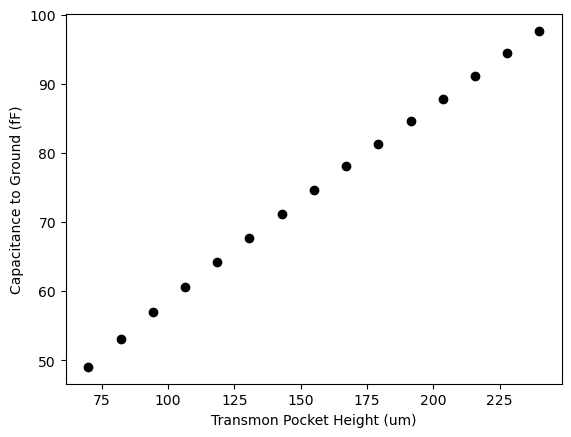

In [70]:
for i, r in enumerate(result_height):
    plt.scatter(heights[i], -r['pad_top_Q1']['ground_main_plane'],color = 'black')
plt.xlabel('Transmon Pocket Height (um)')
plt.ylabel('Capacitance to Ground (fF)')
plt.show()

### Function that takes in frequency and construct qubit design automatically

In [89]:
phi0 = c.h/2/c.e.si
T = 30*u.mK
epsilon_r = 11.7

In [87]:
def transmon_capacitance(Cq, target_freq):
    Cq *= u.fF
    # Cq = 100*u.fF
    Lj = 10*u.nH
    Ec = (c.e.si**2/2/Cq).to(u.J)
    Ej = ((phi0/2/np.pi)**2/Lj).to(u.J)
    # epsilon1 = -Ec*2**9
    wq = (np.sqrt(8*Ej*Ec)-Ec)/c.hbar
    fq = wq/2/np.pi
    alpha = Ec/c.h
    
    return(fq-target_freq)

In [92]:
target_freq = 4.5*u.GHz

target_cap = optimize.fsolve(transmon_capacitance,100, args = (target_freq))[0]*u.fF


In [93]:
target_cap

<Quantity 116.3195991 fF>

In [100]:
width_45 = optimize.fsolve(find_Cap, [250])

INFO 03:22PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 03:23PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 03:23PM [analyze]: Analyzing setup Setup
INFO 03:23PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmposnp6ux5.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 03:23PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpwtcl9ovt.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 03:23PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpmims4c_z.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 03:23PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpjdqe0d07.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.24106          -12.42921    -9.51669
ground_main_plane            -12.42921          140.04010   -87.22105
pad_top_Q1                    -9.51669          -87.22105   100.77634


INFO 03:23PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 03:23PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 03:23PM [analyze]: Analyzing setup Setup
INFO 03:24PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpeijkxbac.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 03:24PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpe69ye0c1.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 03:24PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpcofbvqfe.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 03:24PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpz0a8b6ir.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.24106          -12.42921    -9.51669
ground_main_plane            -12.42921          140.04010   -87.22105
pad_top_Q1                    -9.51669          -87.22105   100.77634


INFO 03:24PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 03:24PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 03:24PM [analyze]: Analyzing setup Setup
INFO 03:25PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp9aocs4m_.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 03:25PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpd_6gnd8l.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 03:25PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp9oiv3haj.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 03:25PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmptxoxsiv3.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.24106          -12.42921    -9.51669
ground_main_plane            -12.42921          140.04010   -87.22105
pad_top_Q1                    -9.51669          -87.22105   100.77634


INFO 03:25PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 03:25PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 03:25PM [analyze]: Analyzing setup Setup
INFO 03:26PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpk7f3qmfc.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 03:26PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmplv41inld.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 03:26PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpxi5fze98.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 03:26PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpjxe379np.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.24145          -12.42895    -9.51726
ground_main_plane            -12.42895          140.03838   -87.22112
pad_top_Q1                    -9.51726          -87.22112   100.77736


INFO 03:26PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 03:26PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 03:26PM [analyze]: Analyzing setup Setup


In [94]:
type(2*u.m)

astropy.units.quantity.Quantity